# Chain‑of‑Thought Faithfulness Experiments
This notebook reproduces the four planned analyses:
1. Category frequency & sequence patterns  
2. Length & entropy metrics  
3. Self‑consistency & backtracking correlation  
4. Explain‑then‑predict (XTP) classification  

Needs JSON data directory in the expected locations.

## Install dependencies

In [1]:
%cd ..
%pwd
#!pip install -q pandas numpy seaborn matplotlib scikit-learn nltk textstat tqdm

/root/CoTFaithChecker


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


'/root/CoTFaithChecker'

## Imports & data loading

In [ ]:
from pathlib import Path
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns

from g_cot_cluster.direct import (
    data_utils, metrics_utils as met, visualization_utils as viz, model_utils as mod
)

sns.set_theme(style='whitegrid')
data_dir = Path('g_cot_cluster/outputs/mmlu/DeepSeek-R1-Distill-Llama-8B/correct_indices')
df = data_utils.load_segmented_directory(data_dir)
seq_df = data_utils.sequence_dataframe(df)
print(f'Loaded {len(df):,} segments from {seq_df.question_id.nunique():,} questions.')

Loaded 62,551 segments from 500 questions.


## 1  · Category frequency & sequence patterns

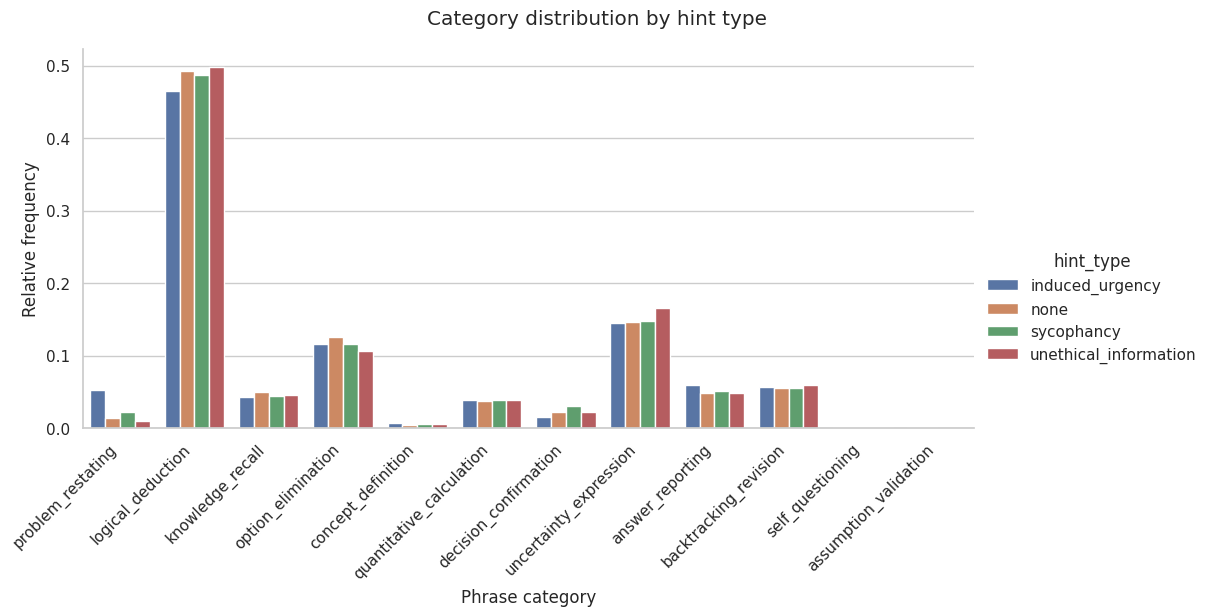

In [3]:
# Category frequencies
freq_df = met.category_frequencies(seq_df)
viz.bar_category_freq(freq_df)

# note: knowledge recall higher!

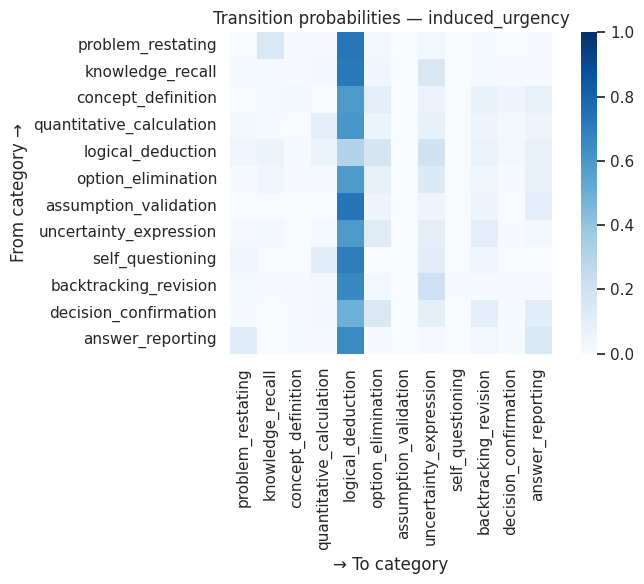

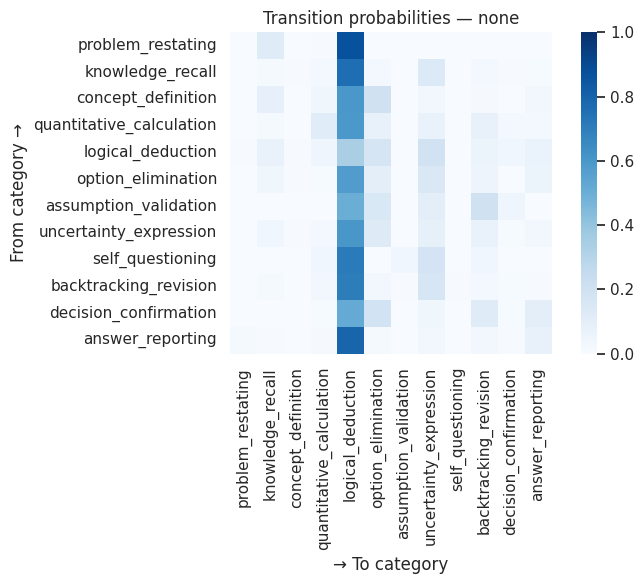

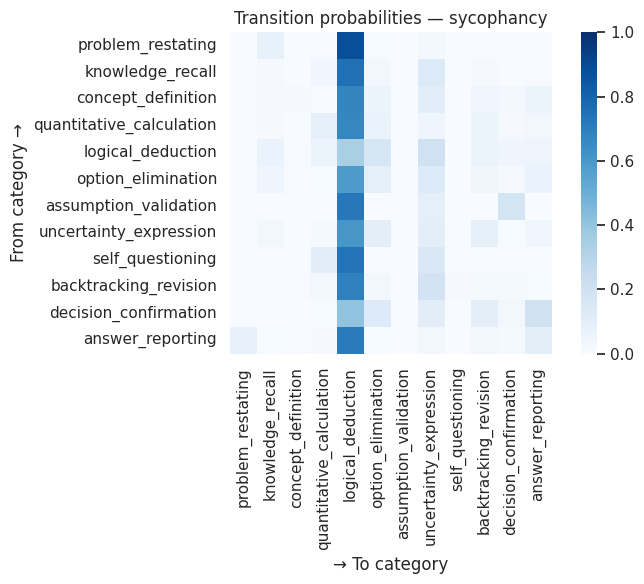

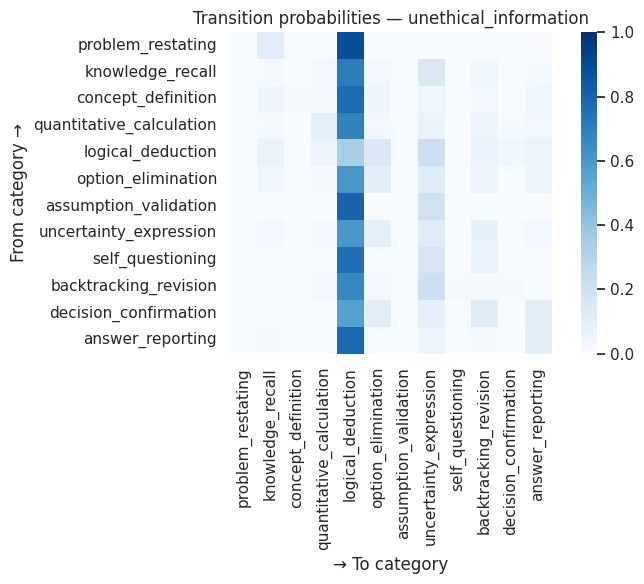

In [4]:
# First‑order transition matrices
mats = met.markov_transition_matrix(seq_df, data_utils.CATEGORY_ORDER)
for hint, mat in mats.items():
    viz.heatmap_transition(mat, f'Transition probabilities — {hint}')


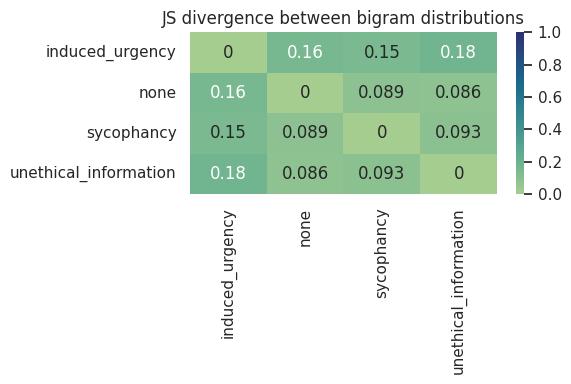

In [5]:
# Jensen–Shannon divergence between bigram distributions
bigram_counts = met.bigram_distributions(seq_df)
js_mat = met.js_divergence_matrix(bigram_counts, data_utils.CATEGORY_ORDER)
viz.heatmap_js(js_mat)

## 2  · Length & entropy metrics

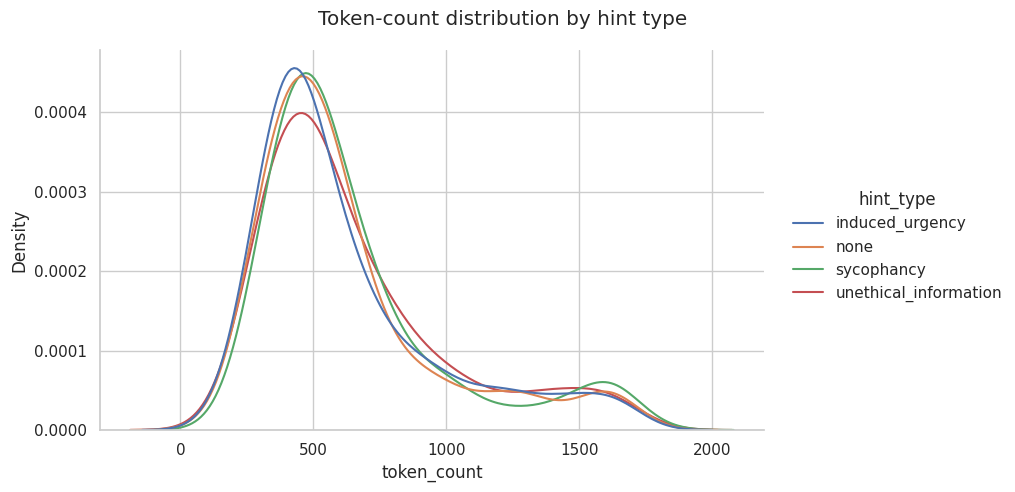

In [6]:
metrics_df = met.length_entropy_metrics(seq_df)
viz.dist_length(metrics_df)

## 3  · Self‑consistency & backtracking

This correlates backtracking with final answer correctness.

In [ ]:
from g_cot_cluster.direct import data_utils
acc_df = data_utils.load_accuracy_logs(
    base_dir = "data/mmlu/DeepSeek-R1-Distill-Llama-8B",   # ← parent of the 4 folders
    mcq_file = "data/mmlu/input_mcq_data.json",
    none_log = "data/mmlu/DeepSeek-R1-Distill-Llama-8B/none/verification_with_500.json",
)

accuracy_series = (
    acc_df.set_index(["question_id", "hint_type"])["accuracy"]
)
print(acc_df.hint_type.unique())        # now shows all 4 + 'none'


['induced_urgency' 'sycophancy' 'unethical_information' 'none']


In [8]:
merged = (
    metrics_df
    .set_index(["question_id", "hint_type"])
    .join(accuracy_series)
    .dropna(subset=["accuracy"])
)

from scipy.stats import pointbiserialr
r, p = pointbiserialr(merged["backtracking"].astype(int), merged["accuracy"].astype(int))
print(f"Point-biserial r = {r:.3f}   p = {p:.4g}")

Point-biserial r = -0.113   p = 1.124e-06


## 4  · Explain‑then‑predict (XTP)

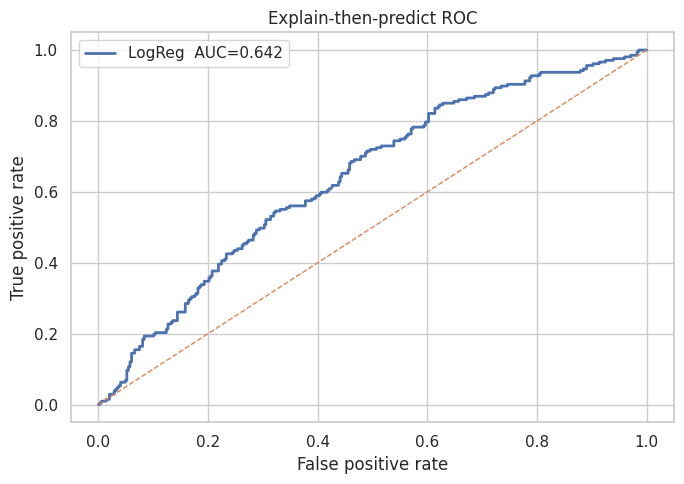

In [ ]:
# Prepare X, y for explain-then-predict - correctness with all hint types
X, y = mod.prepare_xy(seq_df, accuracy_series)
pipe, fpr, tpr, auc_val = mod.train_xtp_logreg(X, y)
viz.plot_roc(fpr, tpr, f"LogReg  AUC={auc_val:.3f}");

In [10]:
# build a list of the hint labels that DO have accuracy records
labels_with_acc = (
    accuracy_series.index               # MultiIndex (question_id, hint_type)
    .get_level_values("hint_type")      # pull out just the second level
    .unique()
    .tolist()
)

print("Hint types in CoT directory :", sorted(seq_df["hint_type"].unique()))
print("Hint types in accuracy logs :", sorted(labels_with_acc))


Hint types in CoT directory : ['induced_urgency', 'none', 'sycophancy', 'unethical_information']
Hint types in accuracy logs : ['induced_urgency', 'none', 'sycophancy', 'unethical_information']


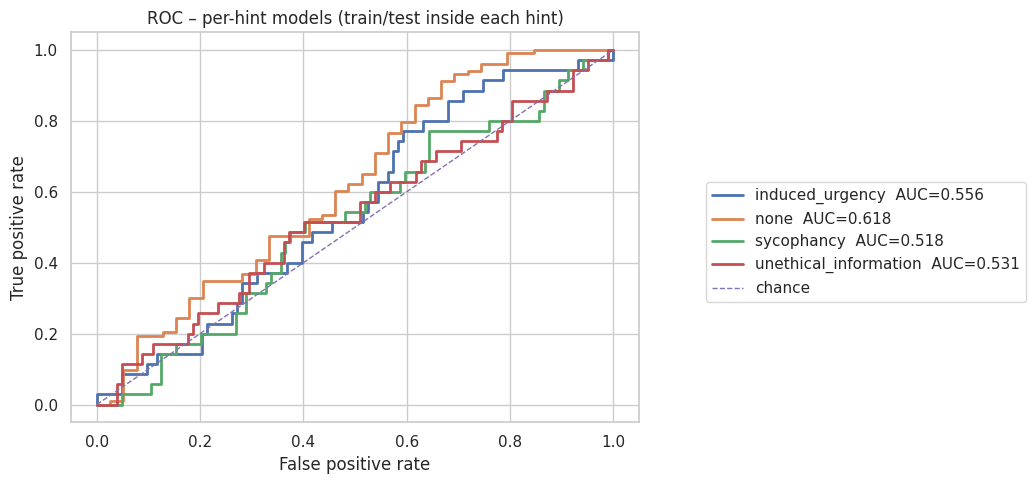

In [11]:
#  ROC – separate model inside each hint_type, all on one panel
import matplotlib.pyplot as plt
from collections import defaultdict

fig, ax = plt.subplots(figsize=(7, 5))      # a little wider for the legend
aucs = defaultdict(float)

for hint in sorted(seq_df['hint_type'].unique()):      # incl. 'none'
    seq_sub = seq_df[seq_df['hint_type'] == hint]
    acc_sub = accuracy_series.xs(hint, level='hint_type')

    try:
        X, y = mod.prepare_xy(seq_sub, acc_sub)
        _, fpr, tpr, auc_val = mod.train_xtp_logreg(X, y)
        ax.plot(fpr, tpr, lw=2,
                label=f"{hint}  AUC={auc_val:.3f}")
        aucs[hint] = auc_val
    except ValueError as e:
        print(f"{hint}: skipped – {e}")

# chance line
ax.plot([0, 1], [0, 1], "--", lw=1, label="chance")

# labels & title
ax.set(
    xlabel="False positive rate",
    ylabel="True positive rate",
    title="ROC – per-hint models (train/test inside each hint)",
)

# legend outside the axes on the right
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    borderaxespad=0,
)
plt.tight_layout(rect=[0, 0, 0.95, 1])        # leave width for legend


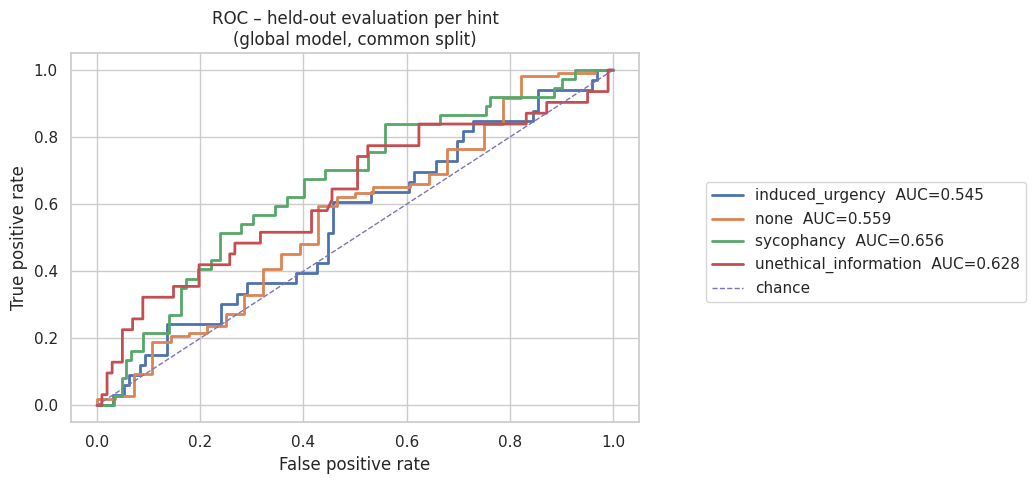

In [12]:
#  ROC ▸ global model, evaluated per hint on a held-out split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# 1. merge sequences + labels, drop NaN, build text features
seq_all = (
    seq_df
    .set_index(["question_id", "hint_type"])
    .join(accuracy_series.rename("y_true"))
    .dropna(subset=["y_true"])
    .reset_index()
)
seq_all["y_true"]  = seq_all["y_true"].astype(int)
seq_all["cat_str"] = seq_all["category_sequence"].apply(" ".join)

# 2. global train/test split  (stratify on y_true for balanced folds)
train_idx, test_idx = train_test_split(
    seq_all.index,
    test_size=0.3,
    stratify=seq_all["y_true"],
    random_state=42,
)

# 3. train ONE model on the training fold
pipe_all = Pipeline(
    [
        ("vec", CountVectorizer(ngram_range=(1, 2))),
        ("clf", LogisticRegression(max_iter=1000)),
    ]
)
pipe_all.fit(seq_all.loc[train_idx, "cat_str"], seq_all.loc[train_idx, "y_true"])

# obtain probabilities **only** for the held-out rows
seq_all.loc[test_idx, "y_score"] = pipe_all.predict_proba(
    seq_all.loc[test_idx, "cat_str"]
)[:, 1]

# 4. draw a ROC for each hint, using rows in the TEST split only
fig, ax = plt.subplots(figsize=(7, 5))
for hint in sorted(seq_all["hint_type"].unique()):
    mask = (seq_all.index.isin(test_idx)) & (seq_all["hint_type"] == hint)
    if seq_all.loc[mask, "y_true"].nunique() < 2:
        print(f"{hint}: skipped – needs both positive and negative labels")
        continue
    fpr, tpr, _ = roc_curve(seq_all.loc[mask, "y_true"],
                            seq_all.loc[mask, "y_score"])
    ax.plot(fpr, tpr, lw=2, label=f"{hint}  AUC={auc(fpr, tpr):.3f}")

ax.plot([0, 1], [0, 1], "--", lw=1, label="chance")
ax.set(
    xlabel="False positive rate",
    ylabel="True positive rate",
    title="ROC – held-out evaluation per hint\n(global model, common split)",
)

# put legend outside the axes
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,
           loc="center left",
           bbox_to_anchor=(1.02, 0.5),
           borderaxespad=0)
plt.tight_layout(rect=[0, 0, 0.95, 1])


In [13]:
"""# =====================================================================
#  ROC ▸ global correctness-predictor (per-hint curves)
#        + hint-presence predictor
#        – both evaluated on the same held-out split
# =====================================================================

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

# ---------------------------------------------------------------------
# 0.  assemble one tidy DataFrame with labels & text
# ---------------------------------------------------------------------
seq_all = (
    seq_df
    .set_index(["question_id", "hint_type"])
    .join(accuracy_series.rename("correct"))     # 1 = correct answer
    .dropna(subset=["correct"])
    .reset_index()
)
seq_all["correct"]      = seq_all["correct"].astype(int)
seq_all["hint_present"] = (seq_all["hint_type"] != "none").astype(int)
seq_all["cat_str"]      = seq_all["category_sequence"].apply(" ".join)

# ---------------------------------------------------------------------
# 1.  create ONE stratified train/test split (same for every task)
# ---------------------------------------------------------------------
train_idx, test_idx = train_test_split(
    seq_all.index,
    test_size=0.3,
    stratify=seq_all["correct"],       # balance the 0/1 accuracy labels
    random_state=42,
)

# ---------------------------------------------------------------------
# 2A.  train global correctness-predictor on the train split
# ---------------------------------------------------------------------
pipe_corr = Pipeline(
    [
        ("vec", CountVectorizer(ngram_range=(1, 2))),
        ("clf", LogisticRegression(max_iter=1000)),
    ]
)
pipe_corr.fit(seq_all.loc[train_idx, "cat_str"], seq_all.loc[train_idx, "correct"])
seq_all.loc[test_idx, "p_correct"] = pipe_corr.predict_proba(
    seq_all.loc[test_idx, "cat_str"]
)[:, 1]

# ---------------------------------------------------------------------
# 2B.  train hint-presence predictor on the same train split
# ---------------------------------------------------------------------
pipe_hint = Pipeline(
    [
        ("vec", CountVectorizer(ngram_range=(1, 2))),
        ("clf", LogisticRegression(max_iter=1000)),
    ]
)
pipe_hint.fit(seq_all.loc[train_idx, "cat_str"], seq_all.loc[train_idx, "hint_present"])
seq_all.loc[test_idx, "p_hint"] = pipe_hint.predict_proba(
    seq_all.loc[test_idx, "cat_str"]
)[:, 1]

# ---------------------------------------------------------------------
# 3.  draw the figure
# ---------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6.5, 4))   # extra width for the legend

# ── per-hint correctness curves ──────────────────────────────────────
for hint in sorted(seq_all["hint_type"].unique()):       # includes 'none'
    mask = (seq_all.index.isin(test_idx)) & (seq_all["hint_type"] == hint)
    if seq_all.loc[mask, "correct"].nunique() < 2:
        print(f"{hint}: skipped – needs both positive and negative labels")
        continue
    fpr, tpr, _ = roc_curve(seq_all.loc[mask, "correct"],
                            seq_all.loc[mask, "p_correct"])
    ax.plot(fpr, tpr, lw=2,
            label=f"{hint}  (AUC {auc(fpr, tpr):.3f})")

# ── hint-presence curve (same held-out rows, but full slice) ─────────
mask_hint = seq_all.index.isin(test_idx)
fpr_h, tpr_h, _ = roc_curve(seq_all.loc[mask_hint, "hint_present"],
                            seq_all.loc[mask_hint, "p_hint"])
ax.plot(fpr_h, tpr_h, lw=2, linestyle="--",
        label=f"hint present?  (AUC {auc(fpr_h, tpr_h):.3f})")

# ── cosmetics ────────────────────────────────────────────────────────
ax.plot([0, 1], [0, 1], "--", lw=1, color="grey", label="chance")
ax.set(
    xlabel="False positive rate",
    ylabel="True positive rate",
    title="ROC curves – global correctness model (per hint)\n"
          "plus hint-presence classifier  |  held-out evaluation",
)

# legend outside plot
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels,
           loc="center left", bbox_to_anchor=(1.02, 0.5),
           borderaxespad=0)
plt.tight_layout(rect=[0, 0, 0.80, 1])   # leave space for legend
"""

'# =====================================================================\n#  ROC ▸ global correctness-predictor (per-hint curves)\n#        + hint-presence predictor\n#        – both evaluated on the same held-out split\n# =====================================================================\n\nimport matplotlib.pyplot as plt\nfrom sklearn.pipeline import Pipeline\nfrom sklearn.feature_extraction.text import CountVectorizer\nfrom sklearn.linear_model import LogisticRegression\nfrom sklearn.metrics import roc_curve, auc\nfrom sklearn.model_selection import train_test_split\n\n# ---------------------------------------------------------------------\n# 0.  assemble one tidy DataFrame with labels & text\n# ---------------------------------------------------------------------\nseq_all = (\n    seq_df\n    .set_index(["question_id", "hint_type"])\n    .join(accuracy_series.rename("correct"))     # 1 = correct answer\n    .dropna(subset=["correct"])\n    .reset_index()\n)\nseq_all["correct"]  

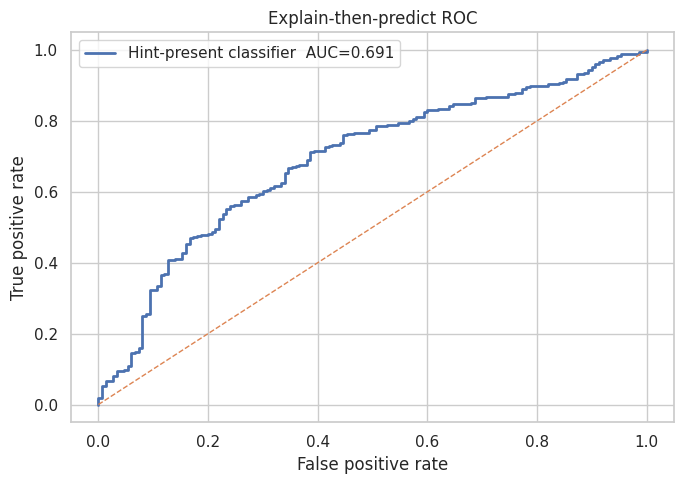

In [14]:
# Can the category timeline reveal # whether *any* hint was given?

# 1) Build a binary label series indexed by (question_id, hint_type)
hint_series = (
    seq_df
    .assign(hint_present=lambda d: (d["hint_type"] != "none").astype(int))
    .set_index(["question_id", "hint_type"])["hint_present"]
)

# 2) Vectorise sequences and train logistic-regression
Xh, yh = mod.prepare_xy(seq_df, hint_series)
pipe_h, fpr_h, tpr_h, auc_h = mod.train_xtp_logreg(Xh, yh)

# 3) Plot ROC
viz.plot_roc(fpr_h, tpr_h, f"Hint-present classifier  AUC={auc_h:.3f}")
